In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

In [3]:
import os
import sys
module_path = os.path.join(os.getcwd(), '..')
sys.path.append(module_path)

In [4]:
from lrp_engine import LRPEngine

In [5]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
model.to("cuda")

DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [7]:
from datasets import load_dataset

dataset = load_dataset("squad_v2")

In [8]:
ds = [ example for example in dataset["validation"] if example["answers"]["text"] ]

In [42]:
example = ds[3]
question = example["question"]
context = example["context"]
prompt = context + " " + question
input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(model.device)

In [43]:
output = model(input_ids)

In [44]:
logit = output.last_hidden_state.max()

In [12]:
lrp = LRPEngine()

In [45]:
checkpoint_rels, param_rels = lrp.run(logit.unsqueeze(0))

In [46]:
param_rels[0].shape

torch.Size([1, 167])

In [47]:
prompt

'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. Who was the Norse leader?'

emerged initially identity[SEP] in
torch.return_types.topk(
values=tensor([[0.1806, 0.0023, 0.0016, 0.0006, 0.0005]], device='cuda:0'),
indices=tensor([[138, 139, 133, 166, 140]], device='cuda:0'))


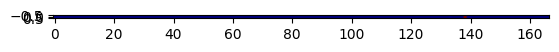

In [48]:
from matplotlib import pyplot as plt

plt.imshow(param_rels[0].cpu(), cmap="jet")

print(tokenizer.decode(input_ids[0][param_rels[0].topk(5).indices][0]))
print(param_rels[0].topk(5))